In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
%%time
import uproot
import numpy as np
cut_based = True
cut_based_version='v4'
r_denom = {}
z_denom = {}
r_nom = {}
z_nom = {}
r_nRechits = {}
z_nRechits = {}
weight_nom = {}
weight_denom = {}
weight_nRechits = {}
llp_r = {}
llp_z = {}
weight_llp = {}
decay = 'bbbb'
lumi = [ 35.9, 41.5, 59.7 ]
for m in [ '15', '40','55']:
    r_denom[m] = []
    z_denom[m] = []
    r_nom[m] = []
    z_nom[m] = []
    r_nRechits[m] = []
    z_nRechits[m] = []
    weight_nom[m] = []
    weight_denom[m] = []
    weight_nRechits[m] = []
    llp_r[m] = []
    llp_z[m] =[]
    weight_llp[m] = []
    for i, year in enumerate(["MC_Summer16", "MC_Fall17", "MC_Fall18"]):
        analyzer_version = "/v1/v108/"
        path = "/storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/"+year+analyzer_version+"normalized/"
        root_dir =uproot.open(path+"ggH_HToSSTo"+decay+"_MH-125_MS-"+m+".root")
        T = root_dir['MuonSystem']
        sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
        ########### SELECTION: EVENTS ############
        hlt = T['HLTDecision'].array()
        
#         sel_llp = np.abs(T.array('gLLP_eta'))<3
#         sel_llp = np.logical_and(sel_llp, T.array('gLLP_decay_vertex_r')<800)
#         sel_llp = np.logical_and(sel_llp, np.abs(T.array('gLLP_decay_vertex_z'))<1200)
#         sel_llp = np.logical_and(sel_llp, np.abs(T.array('gLLP_decay_vertex_z'))>200)
#         sel_ev = np.sum(sel_llp,axis = 1) == 1

        sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 1
        

        
        
        
        sel_ev   = np.logical_and(sel_ev ,T.array('METNoMuTrigger'))
        sel_ev = np.logical_and(sel_ev ,T.array('metEENoise') >= 200)
        sel_ev  = np.logical_and(sel_ev, T.array('category') == 0)
        sel_ev = np.logical_and(sel_ev ,T.array('nLeptons') == 0)
        sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
        sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
        sel_llp = T.array('gLLP_csc')[sel_ev] == 1

        llp_r[m] += list(np.abs(T.array('gLLP_decay_vertex_r'))[sel_ev][sel_llp])
        llp_z[m] += list(np.abs(T.array('gLLP_decay_vertex_z'))[sel_ev][sel_llp])
        weight_llp[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i])

        cluster_index = '3'

        ########### SELECTION: CLUSTERS ############
        sel_rechitcluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc')
        sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)

        r_denom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten())
        z_denom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten())
        weight_denom[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i])


        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster'+cluster_index+'Time') > -5.0, T.array('cscRechitCluster'+cluster_index+'Time') < 12.5))
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.1)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0)

        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10)
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_MB1_0p4') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0)
        sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)



        ##### bdt variables ####


        cscRechitClusterAvgStation = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterNStation = T.array('cscRechitCluster' + cluster_index + 'NStation5')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterEta = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterPhi = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterAvgStation10 = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterNStation10 = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev].flatten()


        if cut_based_version == 'v4':
            cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==2, np.abs(cscRechitClusterEta) < 1.6)
            cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==3, np.abs(cscRechitClusterEta) < 1.6)
            cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==4, np.abs(cscRechitClusterEta) < 1.8)
            cond1 = np.logical_and(cscRechitClusterNStation10==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10)==1, cond2), np.logical_or(cond3, cond4)))
            cond2 = np.logical_and(cscRechitClusterNStation10 > 1, np.abs(cscRechitClusterEta) < 1.9)
            bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
        # sel_rechitcluster = np.logical_and(sel_rechitcluster, bdt_score >= BDT_CUT)
        # sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()>=1)
        else:
            print("ERROR")

        r_nom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel])
        z_nom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel])
        weight_nom[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel]*lumi[i])

        nRechitscut = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev].flatten()[bdt_sel]

        r_nRechits[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130])
        z_nRechits[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130])
        weight_nRechits[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel][nRechitscut>=130]*lumi[i])

CPU times: user 5.39 s, sys: 175 ms, total: 5.56 s
Wall time: 5.49 s


# Efficiency vs. Decay Position

0.4457085890336929 1.0 1.0
0.4457085890336929


here 0.24199999682605267
cut_based_v4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


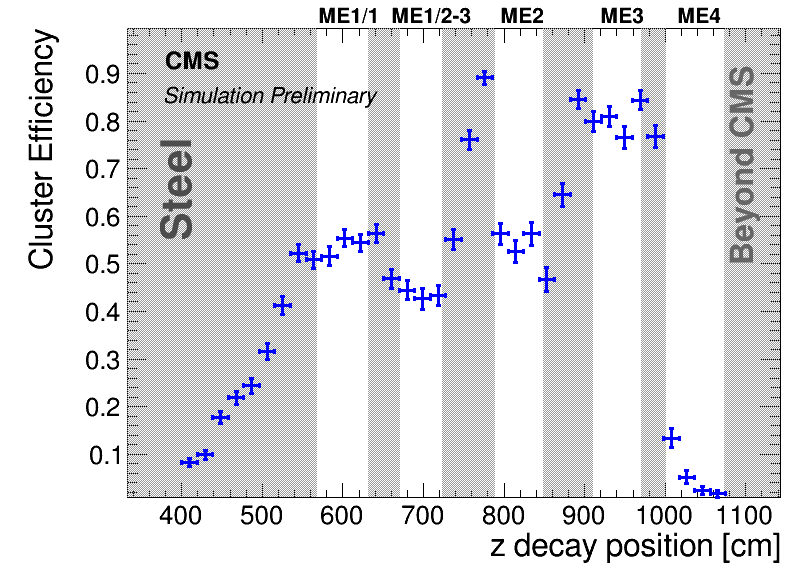

In [6]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])


names = ['cluster_efficiency', 'sig_eff', 'nRechit_efficiency']
m = '40'
for name in names:
    for r in [0,1]:
        if r == 1:continue
        if not name == 'cluster_efficiency':continue
        c = rt.TCanvas('c','c', 800, 600)
        if r:
            bins = [20,0,700]
            xaxis_title = 'LLP decay R [cm]'
        else:
            bins = [35, 550, 1075]
            bins = [35, 400, 1075]


            xaxis_title = 'z decay position [cm]'

            # hm = create_TH1D(cscRechitCluster_match_gLLP_r[eta.flatten()==True].flatten(), 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        # hb = create_TH1D(cscRechitCluster_match_gLLP_r.flatten(), 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        if r:
            if name == 'cluster_efficiency':
                hm = create_TH1D(r_denom[m], 'hb1', axis_title = [xaxis_title,'Cluster Efficiency'], binning=bins, weights = weight_denom[m])
                hb = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Cluster Efficiency'], binning=bins, weights = weight_llp[m])
            elif name == 'sig_eff':
                hm = create_TH1D(r_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                hb = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
            else:
                hm = create_TH1D(r_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                hb = create_TH1D(r_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])
        else:
        #     if name == 'cluster_efficiency':hm = create_TH1D(z_denom, 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        #     else: hm = create_TH1D(z_nom, 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        #     hb = create_TH1D(llp_z, 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
            if name == 'cluster_efficiency':
                hm = create_TH1D(z_denom[m], 'hb1', axis_title = [xaxis_title,'Cluster Efficiency'], binning=bins, weights = weight_denom[m])
                hb = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Cluster Efficiency'], binning=bins, weights = weight_llp[m])
            elif name == 'sig_eff':
                hm = create_TH1D(z_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                hb = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
            else:
                hm = create_TH1D(z_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                hb = create_TH1D(z_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])


        print(hm.Integral()/hb.Integral(), len(z_denom)/len(llp_z), len(r_denom)/len(llp_r))

        pEff1 = rt.TEfficiency(hm,hb)
        print(hm.Integral()/hb.Integral())
        pEff1.SetLineColor(std_color_list[2])


#         pEff1.SetLineColor(std_color_list[2])

        pEff1.SetLineWidth(3)
        pEff1.Draw()

        


#         tdrstyle.setTDRStyle()
        


    
        c.Draw()
        pEff1.GetPaintedGraph().GetHistogram().GetYaxis().SetTitleOffset(0.0);



        ymax = pEff1.GetPaintedGraph().GetHistogram().GetMaximum()
        if name == 'nRechit_efficiency' and r == 1:ymax*=1.05
        ymin = pEff1.GetPaintedGraph().GetHistogram().GetMinimum()
        xmin = pEff1.GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
        xmax = pEff1.GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()
        pEff1.GetPaintedGraph().GetHistogram().SetMaximum(ymax)
        print()
        if r:
            l = rt.TLine(350,ymin, 350, ymax)
            l.SetLineWidth(2)
            l.SetLineStyle(2)
            l.Draw()
            text = rt.TLatex()
            text.SetTextSize(0.05)
            text.DrawLatex(max(50,xmin+25), ymax*0.92, "Inner ring")
            text.DrawLatex(400, ymax*0.92, "Outer ring")
        else:
            boxes = []

            boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
            boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
            boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
            boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
            boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
            boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
            for b in boxes:
                b.SetFillColor(15)
                b.SetFillStyle(3001)
                b.Draw('same')

        
            l = rt.TLatex()
            l.SetTextSize(0.08)
            l.SetTextColor(12)
            l.SetTextAngle(90)
#             l.DrawLatex(xmin+80, ymax*0.6, "Steel")

            l.DrawLatex(xmin+80, ymax*0.55, "Steel")

            l2 = rt.TLatex()
            l2.SetTextSize(0.06)
            l2.SetTextColor(13)
            l2.SetTextAngle(90)
            l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(570, ymax*1.01, "ME1/1")
            text.DrawLatex(660, ymax*1.01, "ME1/2-3")
            text.DrawLatex(795, ymax*1.01, "ME2")
            text.DrawLatex(920, ymax*1.01, "ME3")
            text.DrawLatex(1015, ymax*1.01, "ME4")
            
            
        CMS_lumi.cmsText     = "CMS"
        CMS_lumi.iPos=11
        CMS_lumi.relPosX = 0.1
        CMS_lumi.relPosY = 0.05        
        CMS_lumi.writeExtraText = 1
        CMS_lumi.extraText   = "Simulation Preliminary"
#         CMS_lumi.extraText   = "Simulation Supplementary"


        CMS_lumi.CMS_lumi(c, 0, 11)
        pEff1.Draw('same')


        if cut_based: bdt_name = "cut_based_"+cut_based_version
        print(bdt_name)
        outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version
        if not os.path.isdir(outDir):os.makedirs(outDir)
        fileName = outDir+name+"_"
        if r: fileName += "r_denomAllLLP_m"+m
        else:fileName += "z_denomAllLLP_m"+m
        if CMS_lumi.writeExtraText and CMS_lumi.extraText == "Simulation Preliminary": fileName += "_pas"
        elif CMS_lumi.writeExtraText and CMS_lumi.extraText == "Simulation Supplementary": fileName += "_paper"


            
#         c.SaveAs(fileName + ".png")
#         c.SaveAs(fileName + ".pdf")
#         c.SaveAs(fileName + ".C")


# Efficiency vs. Decay position (2D)

0.19611930510604017 1.0 1.0
1047.5 376.25 0.005027951862373523
592.5 408.75 0.009024175628586203
627.5 441.25 0.008929624312382775
522.5 603.75 0.009266820395268731
767.5 701.25 0.0008304394979433575

21 21
cut_based_v4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/cut_based_v4/v1/v108/2D_sig_eff_bbbb_m15.C has been generated
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/cut_based_v4/v1/v108/2D_sig_eff_bbbb_m15.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analys

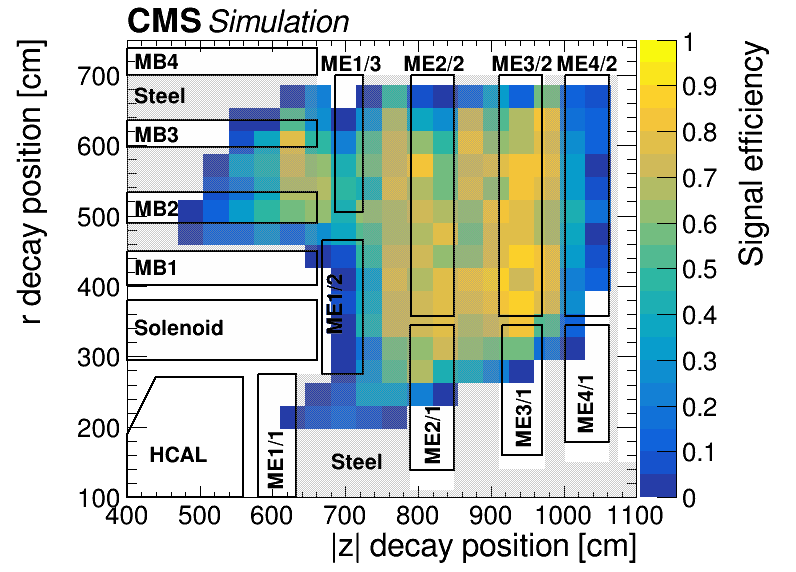

In [37]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])


names = ['sig_eff']
for m in ['15', '40', '55']:  
    if not m == '15':continue
    c = rt.TCanvas('c','c', 800, 600)
    bins = [20, 400, 1100, 20,100,750]
    # bins = [10,100,700, 20, 550, 1075]


#     title = ['Decay R [cm]', 'Decay Z [cm]']
    title = ['r decay position [cm]', '|z| decay position [cm]']


    hm = create_TH2D(np.column_stack((z_nom[m],r_nom[m])), 'hm1', axis_title = [title[1], title[0], 'Signal efficiency'], binning=bins, weights = weight_nom[m])
    hb = create_TH2D(np.column_stack((llp_z[m],llp_r[m])), 'hb1', axis_title = [title[1], title[0],'Signal efficiency'], binning=bins, weights = weight_llp[m])


    print(hm.Integral()/hb.Integral(), len(z_denom)/len(llp_z), len(r_denom)/len(llp_r))

    pEff1 = rt.TEfficiency(hm,hb)
    hist = hm.Clone()
    
    
    for y in range(1, hm.GetYaxis().GetNbins()+1):
            for x in range(1, hm.GetXaxis().GetNbins()+1):
                global_bin = pEff1.GetGlobalBin(x,y)
                if pEff1.GetEfficiency(global_bin)<0.01 and pEff1.GetEfficiency(global_bin)>0:
                    print(hm.GetXaxis().GetBinCenter(x), hm.GetYaxis().GetBinCenter(y), pEff1.GetEfficiency(global_bin))
                    pEff1.SetPassedEvents(global_bin, 0)
                if x==hm.GetXaxis().GetNbins():pEff1.SetPassedEvents(global_bin, 0)
                hist.SetBinContent(x,y,pEff1.GetEfficiency(global_bin))

#     pEff1.Draw('colz')
    hist.SetMaximum(1.0)
    hist.Draw('colz')

    c.SetTopMargin(0.07)


    c.SetRightMargin(0.2)
    c.Draw()
    
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = 1
    CMS_lumi.extraText   = "Simulation"
#     CMS_lumi.extraText   = "Simulation Preliminary"


    if( iPos==0 ): CMS_lumi.relPosX = 0.15
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 0, iPos)

    boxes = []
    boxes.append(rt.TBox(400,402,661,449)) #MB1
    boxes.append(rt.TBox(400,490,661,533)) #MB2
    boxes.append(rt.TBox(400,597,661,636)) #MB3
    boxes.append(rt.TBox(400,700,661,738)) #MB4

    boxes.append(rt.TBox(400,295,661,380)) #solenoid


    boxes.append(rt.TBox(791,357,850,700)) #ME2/2
    boxes.append(rt.TBox(911,357,970,700)) #ME3/2
    boxes.append(rt.TBox(1002,357,1063,700)) #ME4/2

    boxes.append(rt.TBox(789,139,850,345)) #ME2/1
    boxes.append(rt.TBox(915,160,970,345)) #ME3/1
    boxes.append(rt.TBox(1002,178,1063,345)) #ME4/1

    boxes.append(rt.TBox(580,100,632,275)) #ME1/1
    boxes.append(rt.TBox(668,275,724,465)) #ME1/2
    boxes.append(rt.TBox(686,505,724,700)) #ME1/3
    boxes.append(create_TGraph([400.5,560,560,440,400.5,400.5],[100.5,100.5,270,270,190,100.5])) #hcal

    for b in boxes:
        b.SetFillColorAlpha(15,0)
        b.SetLineWidth(2)
        b.SetLineColor(1)
    #     b.SetFillStyle(3001)
        b.Draw('l same')

    steel = []
    steel.append(rt.TBox(400,449,661,490)) #MB1
    steel.append(rt.TBox(400,533,661,597)) #MB2
    steel.append(rt.TBox(400,636,661,700)) #MB3
    x=[633,633, 1100, 1100, 1075, 1075, 1063, 1063,1002,1002,975,975,912,912,849,849,789,789,724,724, 633]
    y=[275, 100, 100, 150, 150, 700,700,150,150,700,700,140,140,700,700,110,110,700,700,275,275]
    print(len(x),len(y))
    steel.append(create_TGraph(x,y)) 



    for b in steel:
        b.SetFillColorAlpha(15,0.5)
        b.SetFillStyle(3001)
#         b.SetFillColorAlpha(15,0.9)
        b.Draw('fsame')

    text = rt.TLatex()
    text.SetTextSize(0.04)


    text.DrawLatex(665, 705, "ME1/3")
    text.DrawLatex(780, 705, "ME2/2")
    text.DrawLatex(900, 705, "ME3/2")
    text.DrawLatex(990, 705, "ME4/2")

    text.DrawLatex(410, 415, "MB1")
    text.DrawLatex(410, 500, "MB2")
    text.DrawLatex(410, 605, "MB3")
    text.DrawLatex(410, 708, "MB4")

    text.DrawLatex(680, 140, "Steel")
    text.DrawLatex(410,660, "Steel")
    text.DrawLatex(410, 330, "Solenoid")
    text.DrawLatex(430, 150, "HCAL")

    text.SetTextAngle(90)
    text.DrawLatex(615, 110, "ME1/1")
    text.DrawLatex(695, 331, "ME1/2")
    text.DrawLatex(830, 145, "ME2/1")
    text.DrawLatex(955, 170, "ME3/1")
    text.DrawLatex(1040, 190, "ME4/1")
    

    if cut_based: bdt_name = "cut_based_"+cut_based_version
    print(bdt_name)
    outDir = "/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/"+bdt_name+analyzer_version
    if not os.path.isdir(outDir):os.makedirs(outDir)
    if CMS_lumi.extraText == 'Simulation Preliminary':
        c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+"_pas.C")
        c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+"_pas.pdf")
        c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+"_pas.png")
    else:
        c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+".C")
        c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+".png")
        c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+".pdf")


# cluster efficiency

0.6185403118975853 1.0 1.0
402.5 172.5 0.004290642896977
1077.5 522.5 0.0003154114471244002
762.5 697.5 0.0006064209873458831



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


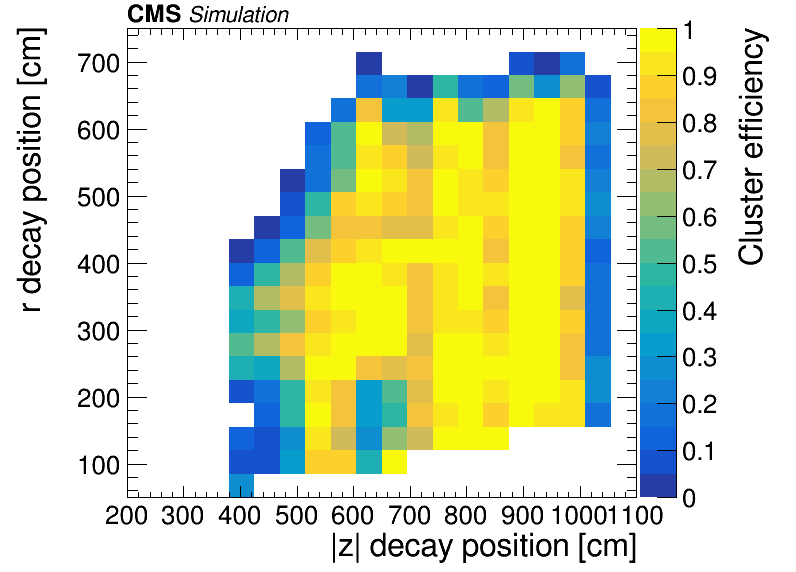

In [15]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])


names = ['sig_eff']
for m in ['15', '40', '55']:  
    if not m == '15':continue
    c = rt.TCanvas('c','c', 800, 600)
    bins = [20, 400, 1100, 20,100,750]
    bins = [20, 200, 1100, 20,50,750]
#     bins = [10,100,700, 20, 550, 1075]


#     title = ['Decay R [cm]', 'Decay Z [cm]']
    title = ['r decay position [cm]', '|z| decay position [cm]']


    hm = create_TH2D(np.column_stack((z_denom[m],r_denom[m])), 'hm1', axis_title = [title[1], title[0], 'Cluster efficiency'], binning=bins, weights = weight_denom[m])
    hb = create_TH2D(np.column_stack((llp_z[m],llp_r[m])), 'hb1', axis_title = [title[1], title[0],'Cluster efficiency'], binning=bins, weights = weight_llp[m])

#     hm = create_TH2D(np.column_stack((z_nom[m],r_nom[m])), 'hm1', axis_title = [title[1], title[0], 'Veto efficiency'], binning=bins, weights = weight_nom[m])
#     hb = create_TH2D(np.column_stack((z_denom[m],r_denom[m])), 'hb1', axis_title = [title[1], title[0],'Veto efficiency'], binning=bins, weights = weight_denom[m])
    print(hm.Integral()/hb.Integral(), len(z_denom)/len(llp_z), len(r_denom)/len(llp_r))

    pEff1 = rt.TEfficiency(hm,hb)
    hist = hm.Clone()
    
    
    for y in range(1, hm.GetYaxis().GetNbins()+1):
            for x in range(1, hm.GetXaxis().GetNbins()+1):
                global_bin = pEff1.GetGlobalBin(x,y)
                if pEff1.GetEfficiency(global_bin)<0.01 and pEff1.GetEfficiency(global_bin)>0:
                    print(hm.GetXaxis().GetBinCenter(x), hm.GetYaxis().GetBinCenter(y), pEff1.GetEfficiency(global_bin))
                    pEff1.SetPassedEvents(global_bin, 0)
                if x==hm.GetXaxis().GetNbins():pEff1.SetPassedEvents(global_bin, 0)
                hist.SetBinContent(x,y,pEff1.GetEfficiency(global_bin))

#     pEff1.Draw('colz')
    hist.SetMaximum(1.0)
    hist.Draw('colz')


    c.SetRightMargin(0.2)
    c.Draw()
    
    
#     rt.gPad.Update()
#     pEff1.GetPaintedGraph().GetHistogram().GetMinimum()
    
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = 1
    CMS_lumi.extraText   = "Simulation"
#     CMS_lumi.extraText   = "Simulation Preliminary"

    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 0, iPos)

    boxes = []
    boxes.append(rt.TBox(400,402,661,449)) #MB1
    boxes.append(rt.TBox(400,490,661,533)) #MB2
    boxes.append(rt.TBox(400,597,661,636)) #MB3
    boxes.append(rt.TBox(400,700,661,738)) #MB4

    boxes.append(rt.TBox(400,295,661,380)) #solenoid


    boxes.append(rt.TBox(791,357,850,700)) #ME2/2
    boxes.append(rt.TBox(911,357,970,700)) #ME3/2
    boxes.append(rt.TBox(1002,357,1063,700)) #ME4/2

    boxes.append(rt.TBox(789,139,850,345)) #ME2/1
    boxes.append(rt.TBox(915,160,970,345)) #ME3/1
    boxes.append(rt.TBox(1002,178,1063,345)) #ME4/1

    boxes.append(rt.TBox(580,100,632,275)) #ME1/1
    boxes.append(rt.TBox(668,275,724,465)) #ME1/2
    boxes.append(rt.TBox(686,505,724,700)) #ME1/3
    boxes.append(create_TGraph([400.5,560,560,440,400.5,400.5],[100.5,100.5,270,270,190,100.5])) #hcal

#     for b in boxes:
#         b.SetFillColorAlpha(15,0)
#         b.SetLineWidth(2)
#         b.SetLineColor(1)
#     #     b.SetFillStyle(3001)
#         b.Draw('l same')

#     steel = []
#     steel.append(rt.TBox(400,449,661,490)) #MB1
#     steel.append(rt.TBox(400,533,661,597)) #MB2
#     steel.append(rt.TBox(400,636,661,700)) #MB3
#     x=[633,633, 1100, 1100, 1075, 1075, 1063, 1063,1002,1002,975,975,912,912,849,849,789,789,724,724, 633]
#     y=[275, 100, 100, 150, 150, 700,700,150,150,700,700,140,140,700,700,110,110,700,700,275,275]
#     print(len(x),len(y))
#     steel.append(create_TGraph(x,y)) 



#     for b in steel:
#         b.SetFillColorAlpha(15,0.7)
#         b.SetFillStyle(3001)
# #         b.SetFillColorAlpha(15,0.9)
#         b.Draw('fsame')

#     text = rt.TLatex()
#     text.SetTextSize(0.04)


#     text.DrawLatex(665, 705, "ME1/3")
#     text.DrawLatex(780, 705, "ME2/2")
#     text.DrawLatex(900, 705, "ME3/2")
#     text.DrawLatex(990, 705, "ME4/2")

#     text.DrawLatex(410, 415, "MB1")
#     text.DrawLatex(410, 500, "MB2")
#     text.DrawLatex(410, 605, "MB3")
#     text.DrawLatex(410, 708, "MB4")

#     text.DrawLatex(680, 140, "Steel")
#     text.DrawLatex(410,660, "Steel")
#     text.DrawLatex(410, 330, "Solenoid")
#     text.DrawLatex(430, 150, "HCAL")

#     text.SetTextAngle(90)
#     text.DrawLatex(615, 110, "ME1/1")
#     text.DrawLatex(695, 331, "ME1/2")
#     text.DrawLatex(830, 145, "ME2/1")
#     text.DrawLatex(955, 170, "ME3/1")
#     text.DrawLatex(1040, 190, "ME4/1")


#     if cut_based: bdt_name = "cut_based_"+cut_based_version
#     print(bdt_name)
#     outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version
#     if not os.path.isdir(outDir):os.makedirs(outDir)
#     if CMS_lumi.extraText == 'Simulation Preliminary':
#         c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+"_pas.C")
#         c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+"_pas.pdf")
#         c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+"_pas.png")
#     else:
#         c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+".C")
#         c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+".png")
#         c.SaveAs(outDir+"2D_sig_eff_"+decay+"_m"+m+".pdf")


# all mass points

0.7873868033618728 0.7670046994805837 0.7670046994805837
0.8206696134066974 0.7969793986636972 0.7969793986636972
0.8314294232515538 0.8083234244946492 0.8083234244946492

cut_based_v4
0.7680359800740263 0.7670046994805837 0.7670046994805837
0.7975555404608597 0.7969793986636972 0.7969793986636972
0.8094402892794881 0.8083234244946492 0.8083234244946492

cut_based_v4
0.30159533224961255 0.7670046994805837 0.7670046994805837
0.2918197996088982 0.7969793986636972 0.7969793986636972
0.2716998961015295 0.8083234244946492 0.8083234244946492

cut_based_v4
0.294183323369246 0.7670046994805837 0.7670046994805837
0.2836007257879486 0.7969793986636972 0.7969793986636972
0.26449967480659947 0.8083234244946492 0.8083234244946492

cut_based_v4
0.8286179587667978 0.7670046994805837 0.7670046994805837
0.8478436241185866 0.7969793986636972 0.7969793986636972
0.8535898119050582 0.8083234244946492 0.8083234244946492

cut_based_v4
0.8286179587667978 0.7670046994805837 0.7670046994805837
0.847843624118586

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing effici

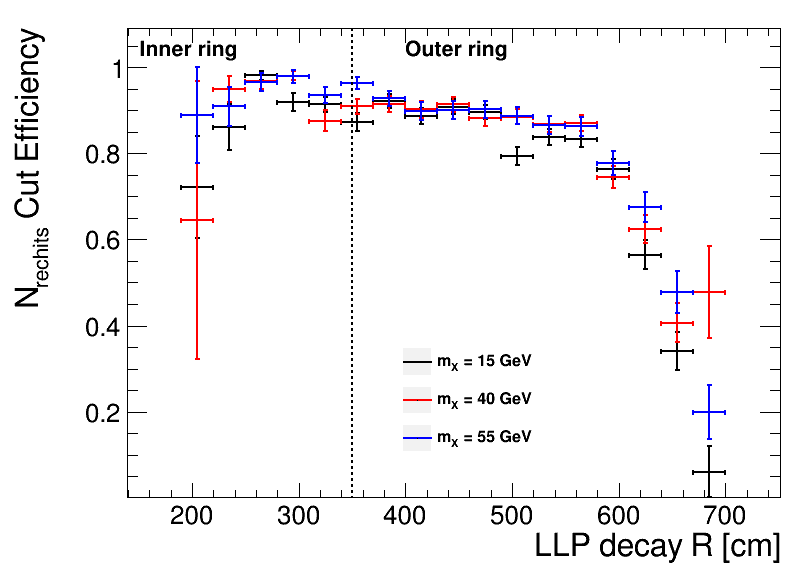

In [16]:
import numpy.ma as ma
import ROOT as rt
import os

names = ['cluster_efficiency', 'sig_eff', 'nRechit_efficiency']

for name in names:
#     if not name == 'sig_eff':continue
    for r in [0,1]:
#         if r == 1:continue
        c = rt.TCanvas('c','c', 800, 600)
        if 'cluster' in name: leg = rt.TLegend(0.24,0.2,0.4,0.4)
        elif 'sig_eff' in name:leg = rt.TLegend(0.24,0.65,0.4,0.85)
        else:leg = rt.TLegend(0.5,0.2,0.7,0.4)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        if r:
            bins = [20,100,700]
            xaxis_title = 'LLP decay R [cm]'
        else:
            bins = [35, 550, 1075]
            xaxis_title = 'LLP decay Z [cm]'
        hm = {}
        hb = {}
        pEff1 = {}
        for i, m in enumerate(r_denom.keys()):
            if r:
                if name == 'cluster_efficiency':
                    hm[m] = create_TH1D(r_denom[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[m])
                    hb[m] = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                elif name == 'sig_eff':
                    hm[m] = create_TH1D(r_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                    hb[m] = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                else:
                    hm[m] = create_TH1D(r_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                    hb[m] = create_TH1D(r_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])
            else:
                if name == 'cluster_efficiency':
                    hm[m] = create_TH1D(z_denom[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[m])
                    hb[m] = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                elif name == 'sig_eff':
                    hm[m] = create_TH1D(z_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                    hb[m] = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                else:
                    hm[m] = create_TH1D(z_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                    hb[m] = create_TH1D(z_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])


            print(hm[m].Integral()/hb[m].Integral(), len(z_denom[m])/len(llp_z[m]), len(r_denom[m])/len(llp_r[m]))

            pEff1[m] = rt.TEfficiency(hm[m],hb[m])
            pEff1[m].SetLineColor(std_color_list[i])
            leg.AddEntry(pEff1[m],"m_{X} = "+m+" GeV")


            pEff1[m].SetLineWidth(2)
            pEff1[m].Draw('' if i == 0 else 'same')

        c.Draw()


        ymax = pEff1['15'].GetPaintedGraph().GetHistogram().GetMaximum()
        ymin = pEff1['15'].GetPaintedGraph().GetHistogram().GetMinimum()
        xmin = pEff1['15'].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
        xmax = pEff1['15'].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()

        print()
        if r:
            l = rt.TLine(350,ymin, 350, ymax)
            l.SetLineWidth(2)
            l.SetLineStyle(2)
            l.Draw()
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(150, ymax*0.94, "Inner ring")
            text.DrawLatex(400, ymax*0.94, "Outer ring")
        else:
            boxes = []

            boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
            boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
            boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
            boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
            boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
            boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
            for b in boxes:
                b.SetFillColor(15)
                b.SetFillStyle(3001)
                b.Draw('same')
            l = rt.TLatex()
            l.SetTextSize(0.08)
            l.SetTextColor(12)
            l.SetTextAngle(90)
            l.DrawLatex(550, ymax*0.7, "Steel")
            l2 = rt.TLatex()
            l2.SetTextSize(0.06)
            l2.SetTextColor(13)
            l2.SetTextAngle(90)
            l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(570, ymax*1.01, "ME1/1")
            text.DrawLatex(660, ymax*1.01, "ME1/2-3")
            text.DrawLatex(795, ymax*1.01, "ME2")
            text.DrawLatex(920, ymax*1.01, "ME3")
            text.DrawLatex(1015, ymax*1.01, "ME4")
        leg.Draw()


        if cut_based: bdt_name = "cut_based_"+cut_based_version
        print(bdt_name)
        outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version+'/'
        if not os.path.isdir(outDir):os.makedirs(outDir)
        if r:
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_mcomp.png")
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_mcomp.C")
        else:
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_mcomp.png")
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_mcomp.C")





# year comparison

In [8]:
%%time
import uproot
import numpy as np
cut_based = True
cut_based_version='v4'
r_denom = {}
z_denom = {}
r_nom = {}
z_nom = {}
r_nRechits = {}
z_nRechits = {}
weight_nom = {}
weight_denom = {}
weight_nRechits = {}
llp_r = {}
llp_z ={}
weight_llp = {}

m = '55'
lumi = [ 35.9, 41.5, 59.7 ]
years = ["MC_Summer16", "MC_Fall17", "MC_Fall18"]
for i, year in enumerate(years):
    analyzer_version = "/v1/v108/"
    path = "/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/"+year+analyzer_version+"normalized/"
    root_dir =uproot.open(path+"ggH_HToSSTobbbb_MH-125_MS-"+m+".root")
        
        
    T = root_dir['MuonSystem']
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 1
    sel_ev   = np.logical_and(sel_ev ,T.array('METNoMuTrigger'))
    sel_ev = np.logical_and(sel_ev ,T.array('met') >= 200)
    sel_ev  = np.logical_and(sel_ev, T.array('category') == 0)
    sel_ev = np.logical_and(sel_ev ,T.array('nLeptons') == 0)
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
    sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_llp = T.array('gLLP_csc')[sel_ev] == 1

    llp_r[year] = np.abs(T.array('gLLP_decay_vertex_r'))[sel_ev][sel_llp]
    llp_z[year] = np.abs(T.array('gLLP_decay_vertex_z'))[sel_ev][sel_llp]
    weight_llp[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i]

    cluster_index = '3'

    ########### SELECTION: CLUSTERS ############
    sel_rechitcluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc')
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)

    r_denom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()
    z_denom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()
    weight_denom[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i]


    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster'+cluster_index+'Time') > -5.0, T.array('cscRechitCluster'+cluster_index+'Time') < 12.5))
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.1)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0)

    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_MB1_0p4') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0)
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)



    ##### bdt variables ####


    cscRechitClusterEta = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev].flatten()
    cscRechitClusterPhi = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev].flatten()
    cscRechitClusterAvgStation10 = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev].flatten()
    cscRechitClusterNStation10 = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev].flatten()



    if cut_based_version == 'v4':
        cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==2, np.abs(cscRechitClusterEta) < 1.6)
        cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==3, np.abs(cscRechitClusterEta) < 1.6)
        cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==4, np.abs(cscRechitClusterEta) < 1.8)
        cond1 = np.logical_and(cscRechitClusterNStation10==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10)==1, cond2), np.logical_or(cond3, cond4)))
        cond2 = np.logical_and(cscRechitClusterNStation10 > 1, np.abs(cscRechitClusterEta) < 1.9)
        bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
    else:print("ERROR")

    r_nom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel]
    z_nom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel]
    weight_nom[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel]*lumi[i]
    
    nRechitscut = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev].flatten()[bdt_sel]

    r_nRechits[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130]
    z_nRechits[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130]
    weight_nRechits[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel][nRechitscut>=130]*lumi[i]

CPU times: user 1.16 s, sys: 22.1 ms, total: 1.18 s
Wall time: 1.47 s


# plotting

cut_based_v4
cut_based_v4
cut_based_v4
cut_based_v4
cut_based_v4
cut_based_v4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing effici

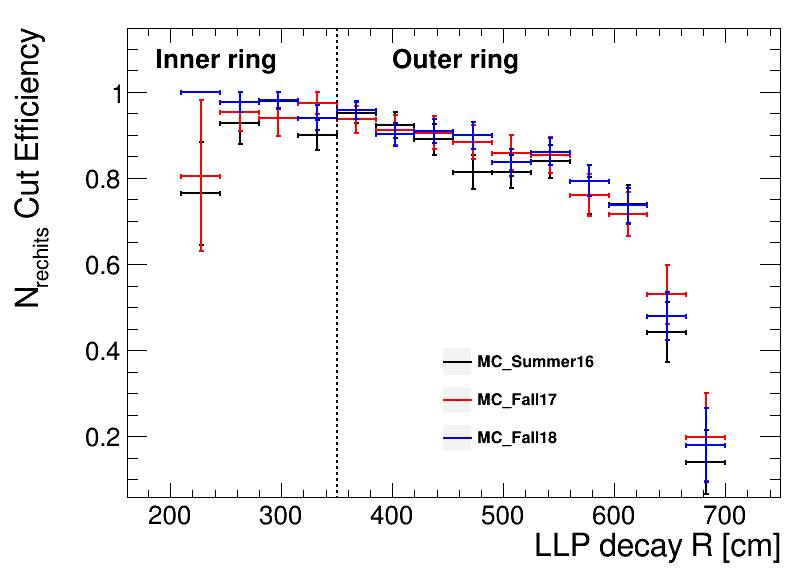

In [9]:
import numpy.ma as ma
import ROOT as rt
hm = {}
hb = {}
pEff1 = {}
names = ['cluster_efficiency', 'sig_eff', 'nRechit_efficiency']

for name in names:
    for r in [0,1]:
#         if not  (name == 'nRechit_efficiency' and r == 0):continue
        c = rt.TCanvas('c','c', 800, 600)
        if 'cluster' in name and r == 1: leg = rt.TLegend(0.30,0.2,0.45,0.4)
        elif 'cluster' in name and r == 0: leg = rt.TLegend(0.38,0.2,0.51,0.4)
        elif 'sig_eff' in name:leg = rt.TLegend(0.30,0.65,0.45,0.85)
        else:leg = rt.TLegend(0.55,0.2,0.75,0.4)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        if r:
            bins = [20,0,700]
            xaxis_title = 'LLP decay R [cm]'
        else:
            bins = [35, 550, 1075]
            bins = [35, 400, 1075]
            xaxis_title = 'LLP decay Z [cm]'

            # hm = create_TH1D(cscRechitCluster_match_gLLP_r[eta.flatten()==True].flatten(), 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        # hb = create_TH1D(cscRechitCluster_match_gLLP_r.flatten(), 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        for i, k in enumerate(years):
            if r:
                if name == 'cluster_efficiency':
                    hm[k] = create_TH1D(r_denom[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[k])
                    hb[k] = create_TH1D(llp_r[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                elif name == 'sig_eff':
                    hm[k] = create_TH1D(r_nom[k], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[k])
                    hb[k] = create_TH1D(llp_r[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                else:
                    hm[k] = create_TH1D(r_nRechits[k], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[k])
                    hb[k] = create_TH1D(r_nom[k], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[k])
            else:

                if name == 'cluster_efficiency':
                    hm[k] = create_TH1D(z_denom[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[k])
                    hb[k] = create_TH1D(llp_z[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                elif name == 'sig_eff':
                    hm[k] = create_TH1D(z_nom[k], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[k])
                    hb[k] = create_TH1D(llp_z[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                else:
                    hm[k] = create_TH1D(z_nRechits[k], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[k])
                    hb[k] = create_TH1D(z_nom[k], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[k])

            pEff1[k] = rt.TEfficiency(hm[k],hb[k])
            pEff1[k].SetLineColor(std_color_list[i])
            pEff1[k].SetLineWidth(2)
            leg.AddEntry(pEff1[k],k)
            pEff1[k].Draw('' if i == 0 else 'same')
        
        c.Draw()


       
        ymax = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetMaximum()
        if (name == 'nRechit_efficiency' or name == 'sig_eff') and r == 1:ymax*=1.05
        ymin = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetMinimum()
        xmin = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
        xmax = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()
        pEff1[years[0]].GetPaintedGraph().GetHistogram().SetMaximum(ymax)
        if r:
            l = rt.TLine(350,ymin, 350, ymax)
            l.SetLineWidth(2)
            l.SetLineStyle(2)
            l.Draw()
            text = rt.TLatex()
            text.SetTextSize(0.05)
            text.DrawLatex(max(50,xmin+25), ymax*0.92, "Inner ring")
            text.DrawLatex(400, ymax*0.92, "Outer ring")
        else:
            boxes = []

            boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
            boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
            boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
            boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
            boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
            boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
            for b in boxes:
                b.SetFillColor(15)
                b.SetFillStyle(3001)
                b.Draw('same')
            l = rt.TLatex()
            l.SetTextSize(0.08)
            l.SetTextColor(12)
            l.SetTextAngle(90)
            l.DrawLatex(xmin+80, ymax*0.6, "Steel")
            l2 = rt.TLatex()
            l2.SetTextSize(0.06)
            l2.SetTextColor(13)
            l2.SetTextAngle(90)
            l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(570, ymax*1.01, "ME1/1")
            text.DrawLatex(660, ymax*1.01, "ME1/2-3")
            text.DrawLatex(795, ymax*1.01, "ME2")
            text.DrawLatex(920, ymax*1.01, "ME3")
            text.DrawLatex(1015, ymax*1.01, "ME4")
        leg.Draw()
        if cut_based: bdt_name = "cut_based_"+cut_based_version
        print(bdt_name)
        outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version
        if not os.path.isdir(outDir):os.makedirs(outDir)
        if r:
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_yComp.png")
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_yComp.C")
        else:
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_yComp.png")
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_yComp.C")


